## Preparation

##### Import Functions

In [1]:
import numpy as np
import pandas as pd
from os import listdir
from skimage import io
from matplotlib import pyplot as plt
from skimage.draw import circle, circle_perimeter
from skimage.color import rgb2hsv, rgb2hed, hed2rgb, rgb2gray
from Scripts.LoadImage import LoadImage as LoadImage
from Scripts.Fuzzify import Fuzzify as Fuzzify
from Class.Helper import Helper as Helper
from Scripts.Ki67 import Ki67 as Ki67
import pickle

##### Functions

In [2]:
from skimage.morphology import binary_closing
from skimage.morphology import disk, remove_small_objects
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage import data, io, segmentation, color
import math
import pandas as pd
from skimage import img_as_uint
from skimage.transform import rescale
from skimage import img_as_ubyte
def getRecall(markers, mask):
    radius = 3
    hits = markers.apply(lambda marker: mask[int(marker['y'])-radius:int(marker['y']) + radius + 1, int(marker['x'])-radius:int(marker['x']) + radius + 1].any(),axis=1)
    recall = hits.sum() / len(hits)
    return recall

def validateResults(folder_name, show_images = False):
    path = settings.data_folder_test
    mask = pickle.load(open(settings.backup_folder + "Images/" + "Test_" + folder_name + "_" + settings.class_1 + "_df_results"  + ".p", "rb"))
    mask = mask.sort_index()
    
    file_path = path + folder_name
    base = io.imread(file_path + "/base.png")
    markers = pd.read_csv(file_path + "/markers.csv")
    
    if settings.class_1 == "brown":
        searched_class = 1
    else:
        searched_class = 2
    try:
        width = math.floor(base.shape[1] / 3)
        mask = np.reshape(np.array(mask["Decision Fuzzy"]), (-1, width))
    except:
        width = math.ceil(base.shape[1] / 3)
        mask = np.reshape(np.array(mask["Decision Fuzzy"]), (-1, width))       
        
    mask = [np.ones(3) if j == settings.class_1 else np.zeros(3) for row in mask for j in row]
    mask = np.array(mask)
    mask = mask.reshape((-1, width, 3))
    k = 3
    markers.loc[:, 'x'] = markers.x.apply(lambda x: np.ceil(x / k))
    markers.loc[:, 'y'] = markers.y.apply(lambda y: np.ceil(y / k))

    markers = markers.loc[markers.type == searched_class]
    markers_number = markers.shape[0]
    if show_images:
        fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(70, 45))

    mask_gray = rgb2gray(mask)

    if show_images:
        ax[0].imshow(mask, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(1))
    if show_images:
        ax[1].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = remove_small_objects(mask_gray, 3)
    if show_images:
        ax[2].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(2))
    if show_images:
        ax[3].imshow(mask_gray, cmap=plt.cm.gray)

    mask_gray = mask_gray.astype(bool)
    recall = getRecall(markers, mask_gray)
    print(recall)

    io.imsave("Images/" + folder_name + "_" + settings.class_1 + "_processed_mask.png", img_as_uint(mask_gray))
    io.imsave("Images/" + folder_name + "_" + settings.class_1 + "_processed_colored.png", img_as_uint(gray2rgb(mask_gray) * rescale(base, 1.0 / 3.0, anti_aliasing=False)))
    if show_images:
        for center_y, center_x in zip(markers.y, markers.x):
            circy, circx = circle_perimeter(int(center_y), int(center_x), 0)
            base[circy, circx] = (220, 20, 20)
        
        ax[4].imshow(base, cmap=plt.cm.gray)
        plt.show()
        
    mask_rgb = img_as_ubyte(gray2rgb(mask_gray))

    for center_y, center_x in zip(markers.y, markers.x):
        try:
            circy, circx = circle_perimeter(int(center_y), int(center_x), 2)
            mask_rgb[circy, circx] = (220, 20, 20)
        except:
            try:
                circy, circx = circle_perimeter(int(center_y), int(center_x), 0)
                mask_rgb[circy, circx] = (220, 20, 20)
            except:
                continue
    io.imsave("Images/" + folder_name + "_" + settings.class_1 + "_processed_labels.png", img_as_uint(mask_rgb))

    return recall, markers_number

##### Import Settings

In [3]:
# from Settings.SettingsKi67 import Settings as Settings
# import Settings.GeneralSettings as generalSettings
# settings = Settings(generalSettings)

##### Load Image

In [4]:
# loadImage = LoadImage()
# samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

### Train mode

In [5]:
# fuzzify = Fuzzify()
# changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)
# print(implicants_number)

### Test mode

D:\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
D:\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


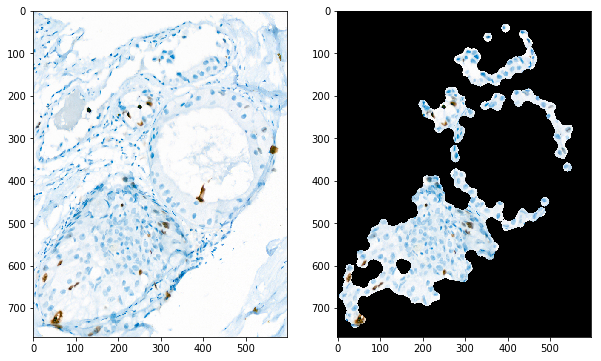

File: ../Data/Ki67-Test/24774-10/base.png
Width: 768	 Height: 597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458496/458496 [10:00<00:00, 763.71it/s]


-----------------------------------------------------------------------------------
Time: 644.9710626602173
-----------------------------------------------------------------------------------
0.2716049382716049


D:\Anaconda\envs\py35\lib\site-packages\skimage\io\_io.py:141: UserWarning: Images/24774-10_blue_processed_mask.png is a low contrast image
  warn('%s is a low contrast image' % fname)
D:\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
D:\Anaconda\envs\py35\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
D:\Anaconda\envs\py35\lib\site-packages\skimage\io\_io.py:141: UserWarning: Images/24774-10_blue_processed_colored.png is a low contrast image
  warn('%s is a low contrast image' % fname)


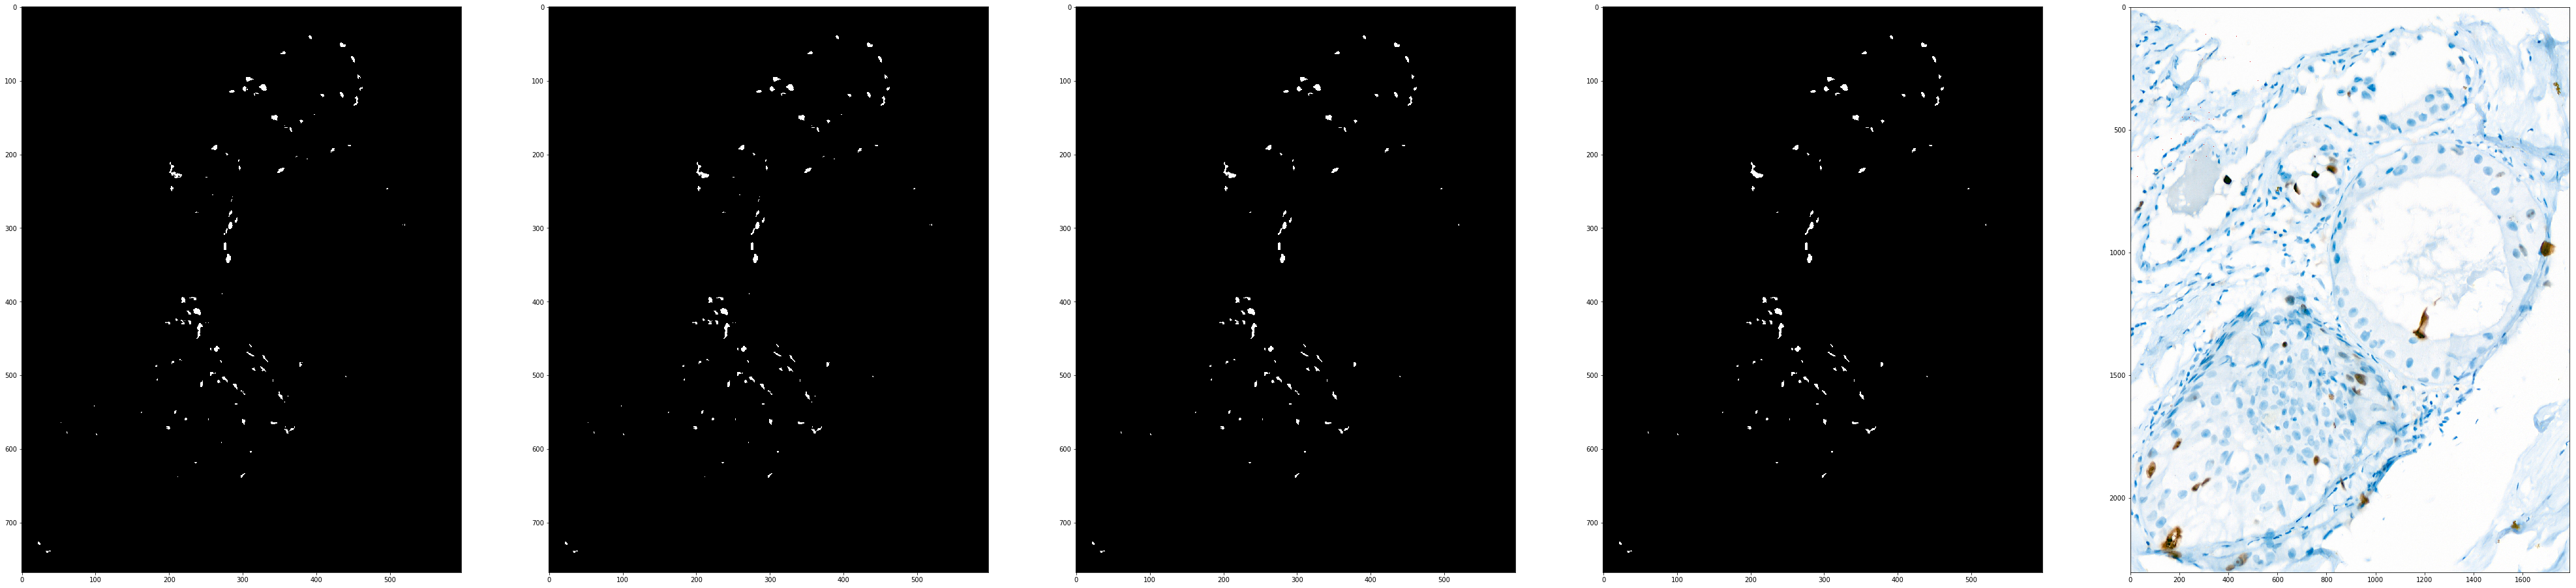

D:\Anaconda\envs\py35\lib\site-packages\skimage\io\_io.py:141: UserWarning: Images/24774-10_blue_processed_labels.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0.2716049382716049


D:\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
D:\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


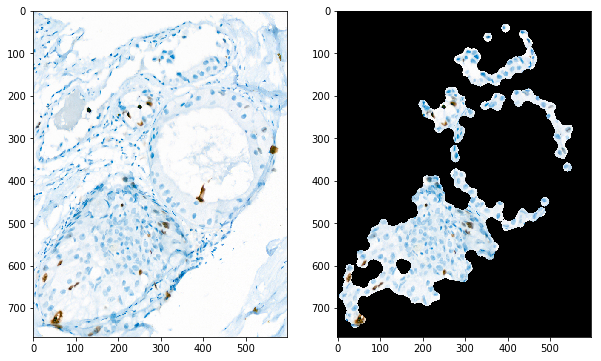

File: ../Data/Ki67-Test/24774-10/base.png
Width: 768	 Height: 597


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458496/458496 [09:57<00:00, 767.88it/s]


-----------------------------------------------------------------------------------
Time: 642.7722115516663
-----------------------------------------------------------------------------------
0.9545454545454546


D:\Anaconda\envs\py35\lib\site-packages\skimage\io\_io.py:141: UserWarning: Images/24774-10_brown_processed_mask.png is a low contrast image
  warn('%s is a low contrast image' % fname)
D:\Anaconda\envs\py35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
D:\Anaconda\envs\py35\lib\site-packages\skimage\util\dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
D:\Anaconda\envs\py35\lib\site-packages\skimage\io\_io.py:141: UserWarning: Images/24774-10_brown_processed_colored.png is a low contrast image
  warn('%s is a low contrast image' % fname)


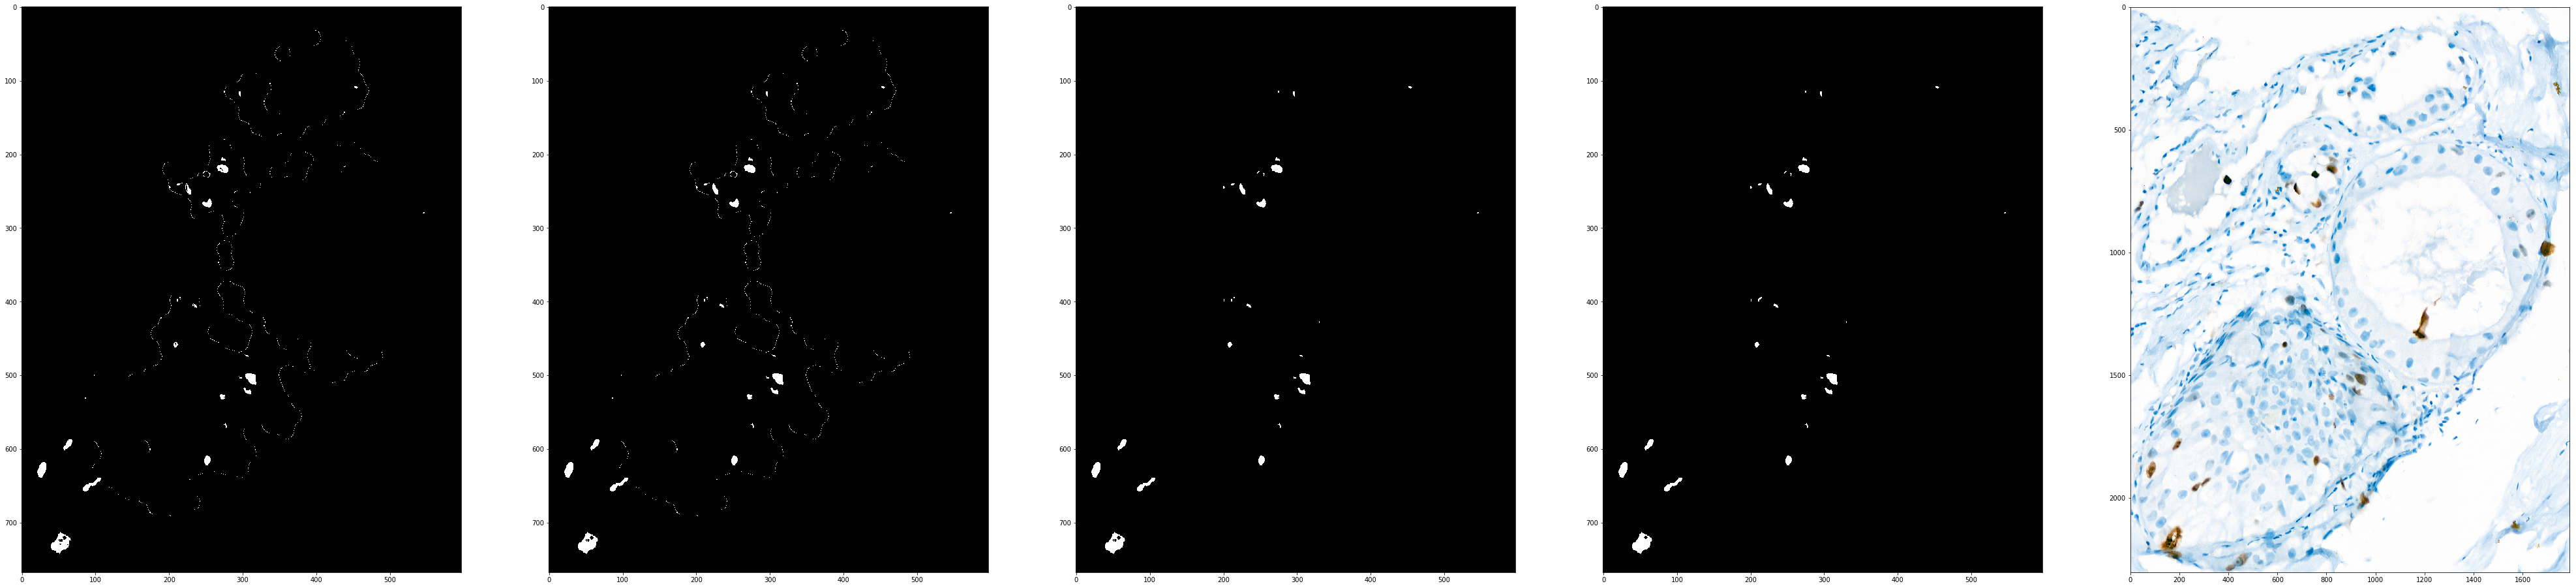

D:\Anaconda\envs\py35\lib\site-packages\skimage\io\_io.py:141: UserWarning: Images/24774-10_brown_processed_labels.png is a low contrast image
  warn('%s is a low contrast image' % fname)


,Image,Resolution,Pixels,Blue Pixels,Blue Recall,Blue Time,Brown Pixels,Brown Recall,Brown Time,Avg. Recall,Total Time
0,10712-09,2240x2944,6594560,1070,0.429907,1781.064893,175,0.777143,1126.435360,0.603525,2907.500252
1,10842-05,2112x2768,5846016,881,0.282633,944.083566,272,0.794118,1230.119378,0.538376,2174.202944
2,1164-03,1504x2112,3176448,723,0.684647,526.004996,63,0.793651,523.222469,0.739149,1049.227465
3,1628-05,3744x3776,14137344,807,0.650558,2411.238772,195,0.866667,4232.114327,0.758612,6643.353100
4,18583-04,4512x6128,27649536,1490,0.391275,9825.107619,348,0.942529,6209.086696,0.666902,16034.194315
5,19051-09,1360x1888,2567680,1040,0.301923,483.030239,82,0.829268,466.999111,0.565596,950.029350
6,22137-04,1584x2384,3776256,264,0.439394,604.770898,114,0.877193,599.253226,0.658293,1204.024124
7,24774-10,2304x1792,4128768,243,0.271605,645.048066,22,0.954545,642.835713,0.613075,1287.883779
8,31374-10,2736x4832,13220352,1353,0.322247,2153.690083,207,0.879227,2614.334425,0.600737,4768.024508
9,503-05,1584x1616,2559744,134,0.664179,354.683446,26,1.000000,355.529940,0.832090,710.213386


In [6]:
helper = Helper()
import time
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings

for name in ["24774-10"]:
    generalSettings.file_name = name
    generalSettings.class_1 = "blue"
    settings = Settings(generalSettings)

    loadImage = LoadImage()
    samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = True)

    ki67Test = Ki67(settings, settings.s_function_width, False)
    start = time.time()
    ki67Test.noOptymalizationWorker(settings)
    end = time.time()
    blue_time = end - start
    blue_recall, markers_number_blue = validateResults(settings.file_name, True)
    print(blue_recall)
    generalSettings.class_1 = "brown"
    settings = Settings(generalSettings)

    loadImage = LoadImage()
    samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = True)

    ki67Test = Ki67(settings, settings.s_function_width, False)
    start = time.time()
    ki67Test.noOptymalizationWorker(settings)
    end = time.time()
    brown_time = end - start

    brown_recall, markers_number_brown = validateResults(settings.file_name, True)
    
    base_res = io.imread(settings.data_folder_test + settings.file_name + "/base.png")
    helper.saveKi67Segmentation([settings.file_name, str(base_res.shape[0]) + "x" + str(base_res.shape[1]), base_res.shape[0] * base_res.shape[1], markers_number_blue, blue_recall, blue_time, markers_number_brown, brown_recall, brown_time, (blue_recall + brown_recall)/2, (blue_time + brown_time)])